# Notebook for data reduction of OTF mapping

In [1]:
# standard library
from datetime import datetime as dt

# dependent packages
import numpy as np
import xarray as xr
import fmflow as fm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
%matplotlib inline
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.dpi'] = 150
plt.rcParams['image.cmap'] = 'viridis'

from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

## Config

In [3]:
path_cal = 'xffts20181004191107.xfftsx.01.nc'
path_sci = 'xffts20181004191139.xfftsx.01.nc'
path_ant = 'lmttpm_2018-10-04_078893_01_0000.nc'

Tamb = 273.0 # K
freq = 128.0-0.1 + np.linspace(0.0, 2.5, 2**15)

## Step 1: Read science (ON and OFF) data

In [4]:
with xr.open_dataset(path_sci) as ds:
    array     = ds['array'].copy().values
    integtime = ds['integtime'].copy().values
    scantype  = ds['bufpos'].copy().values
    scanno    = ds['scancount'].copy().values
    date      = ds['date'].copy().values

# flagging invalid datetime
t_sci = np.array([s[:-4] for s in date], 'datetime64[us]')
flag = t_sci < t_sci[-1]

array     = array[flag]
integtime = integtime[flag]
scantype  = scantype[flag]
scanno    = scanno[flag]
date      = date[flag]
t_sci     = t_sci[flag]

## Step 2: Read antenna data

+ Please execute eather cell below!

### For Az, El coordinates

In [5]:
with xr.open_dataset(path_ant) as ds:
    x_ant = np.rad2deg(ds['Data.TelescopeBackend.TelAzMap'].values)
    y_ant = np.rad2deg(ds['Data.TelescopeBackend.TelElMap'].values)
    unix  = ds['Data.TelescopeBackend.TelTime'].values # unix time

t_ant = np.array([dt.fromtimestamp(t) for t in unix], 'datetime64[us]')
t_ant += np.timedelta64(5, 'h')

### For Ra, Dec coordinates

In [ ]:
with xr.open_dataset(path_ant) as ds:
    x_ant = np.rad2deg(ds['Data.TelescopeBackend.SourceRa'].values)
    y_ant = np.rad2deg(ds['Data.TelescopeBackend.SourceDec'].values)
    unix  = ds['Data.TelescopeBackend.TelTime'].values # unix time

t_ant = np.array([dt.fromtimestamp(t) for t in unix], 'datetime64[us]')
t_ant += np.timedelta64(5, 'h')

## Step 3: Interpolating antenna coordinates

In [6]:
dt_sci = (t_sci - t_ant[0]).astype(np.float64)
dt_ant = (t_ant - t_ant[0]).astype(np.float64)

x_sci = interp1d(dt_ant, x_ant, fill_value='extrapolate')(dt_sci)
y_sci = interp1d(dt_ant, y_ant, fill_value='extrapolate')(dt_sci)

## Step 4: Create FM array (ON, OFF, and R)

In [7]:
tcoords  = {'scanno': scanno, 'x': x_sci, 'y': y_sci, 't': t_sci}
chcoords = {'fsig': freq}

P = fm.array(array/integtime[:,None], tcoords=tcoords, chcoords=chcoords)

Pon  = P[scantype == 'ON']
Poff = P[scantype == 'REF']

In [8]:
with xr.open_dataset(path_cal) as ds:
    array     = ds['array'].copy().values
    integtime = ds['integtime'].copy().values

Pr = fm.array(array/integtime[:,None]).mean('t')

## Step 5: Chopper-wheel calibration

In [9]:
Tcal = fm.zeros_like(Pon)

for no in np.unique(Pon.scanno):
    # ON array of single row
    Pon_ = Pon[Pon.scanno==no]

    # OFF array for single row
    Poff_l = Poff[Poff.scanno==no-1].mean('t')
    Poff_r = Poff[Poff.scanno==no+1].mean('t')
    Poff_ = (Poff_l+Poff_r) / 2
    
    # calibrated array
    Tcal_ = Tamb * (Pon_-Poff_) / (Pr-Poff_)
    Tcal[Tcal.scanno==no] = Tcal_

## Step 6: Baseline subtraction

+ Plase execute eather cell below!

### For continuum observation

In [ ]:
for no in np.unique(Pon.scanno):
    N = Tcal_.shape[0]
    t = xr.DataArray(np.arange(N), dims='t')
    Tbl_ = ((N-1-t)/(N-1)*Tcal_[0]).values + (t/(N-1)*Tcal_[-1]).values

    Tcal[Tcal.scanno==no] -= Tbl_

### For spectral line observation

In [10]:
Tcal -= Tcal.median('ch')

## Step 7: Channel binning and create cube

In [11]:
Tcal_bin = fm.chbinning(Tcal, 8)
cube = fm.tocube(Tcal_bin, gridsize='5arcsec')

## Step 7: Plot results

In [12]:
p = figure(plot_width=1200, plot_height=400, x_axis_type='datetime')
p.line(Tcal.t.values, Tcal[:, 5:].mean('ch').values)
show(p)

In [13]:
p = figure(plot_width=1200, plot_height=400)
p.line(Tcal.fsig.values[10:], Tcal.mean('t').values[10:])
show(p)

In [14]:
p = figure(plot_width=1200, plot_height=400)
p.line(np.arange(Tcal_bin.mean('t').size)[10:], Tcal_bin.mean('t').values[10:])
show(p)

Text(0,0.5,'dEl (arcsec)')

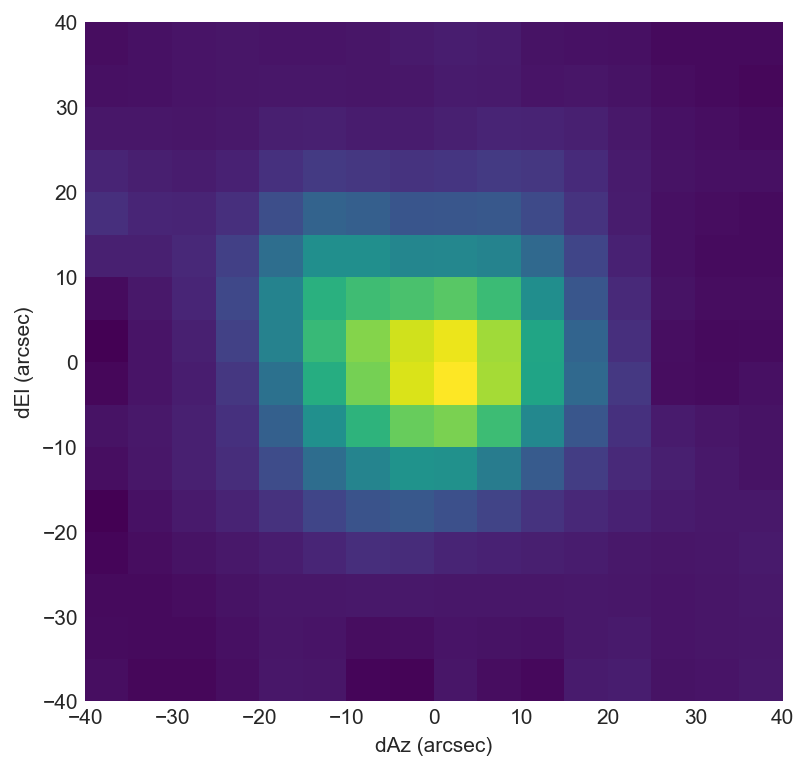

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolormesh(cube.x*3600, cube.y*3600, cube[2028])
ax.set_xlabel('dAz (arcsec)')
ax.set_ylabel('dEl (arcsec)')